In [1]:
from lyricsgenius import Genius
import regex as re
from tqdm import tqdm
from datetime import datetime
import pickle

class Song:

    def __init__(self, ts, title, artists, id):
        self.title = title
        self.artists_raw = list(artists)
        self.artists = ", ".join(self.artists_raw)
        self.id = id
        self.ts = datetime.utcfromtimestamp(int(ts))
        self.a_n_t = f"{self.artists} - {self.title}"

    def __str__(self):
        return self.a_n_t

    def __repr__(self):
        return str(self)

    def __hash__(self):
        return hash(self.__repr__())

    def __eq__(self, other):
        return self.a_n_t.lower() == other.a_n_t.lower() or self.id == other.id
    
with open(f"lyrics_cache_top1.pkl", "rb") as f:
    lyrics_cache = pickle.load(f)

In [2]:
import regex as re
from labMTsimple.storyLab import emotionFileReader

languages_used = set()

#Available languages: English, French, German, Hindi, Indonesian, Korean, Portuguese, Russian, Spanish.
languages = ['english','french','german','hindi','indonesian','korean','portuguese','russian','spanish']
languages_short = set(['en', 'fr', 'de', 'hi', 'id', 'ko', 'pt', 'ru', 'es'])
#Detect languages:
re_chinese = r'\p{IsHan}+'
re_korean = r'\p{IsHangul}+'

re_asian = re_chinese + '|' + re_korean

token_sentiment = {}
for lang in languages:
    _, vector, words = emotionFileReader(stopval=0.0,lang=lang, returnVector=True)
    for word, value in zip(words,vector):
        token_sentiment[word.lower()] = value

In [3]:
from collections import Counter
lyric_lengths = Counter()
for song_data in lyrics_cache:
    for artist_name, artist_id, song, lyric in song_data:
        if lyric is not None and lyric != "FAILED" and len(lyric.lyrics) < 10000:
            lyric_lengths[lyric] = len(lyric.lyrics)

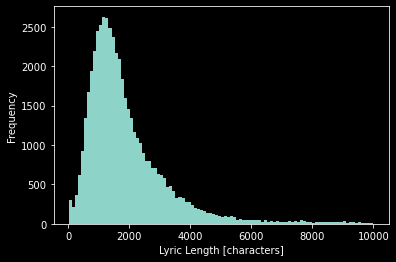

In [4]:
#plot lyrics distribution
from matplotlib import pyplot as plt
plt.hist(lyric_lengths.values(), bins=100)
plt.xlabel("Lyric Length [characters]")
plt.ylabel("Frequency")
plt.show()

In [5]:
import pandas as pd
from tqdm import tqdm
import string
from functools import partial

#Import model for detecting language
from langid.langid import LanguageIdentifier, model

identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
lang_classify = identifier.classify
#Import tokenizers for languages
from nltk.tokenize import word_tokenize #For languages that predominantly use spaces
from konlpy.tag import Okt as Tag#For Korean
konlpy_tokenize = partial(Tag().morphs,norm=True)

df = pd.DataFrame(columns=['artist_id','artist_name','song_id','song_name','lyric_tokens','sentiment','language'])

table = str.maketrans('', '', string.punctuation)
missing_lyrics = set()
with tqdm(total=len(lyrics_cache)) as pbar:
    while len(lyrics_cache) > 0:
        song_data = lyrics_cache.pop()
        pbar.update(1)
        for artist_name, artist_id, song, lyric in song_data:
            if lyric is None or lyric == "FAILED" or len(lyric.lyrics) > 10000:
                missing_lyrics.add(artist_id)
                continue
            lyric_text = lyric.lyrics
            
            #Clean up genius annotations
            genius_intro = lyric.title+" Lyrics"
            if lyric_text.startswith(genius_intro):
                lyric_text = lyric_text[len(genius_intro):]
            if lyric_text.endswith("Embed"):
                lyric_text = lyric_text[:-5]
                
            language_family, prob = lang_classify(lyric_text)

            if not language_family in languages_short or prob < 0.5:
                continue #Skip if unknown language or low confidence
            elif language_family == 'ko':
                tokenize_func = konlpy_tokenize
            else:
                tokenize_func = word_tokenize
            
            lyric_text = lyric_text.translate(table).lower() #Remove punctuation
            
            tokens = [] #Tokens for this lyric
            sentiment = [] #Sentiment for each token
            has_sentiment = [] #Whether or not the token has sentiment score in LabMT
            for tok in tokenize_func(lyric_text):
                tokens.append(tok)
                sentiment.append(token_sentiment.get(tok, 5)-5) #-5 to center LabMT sentiment scores around 0
                has_sentiment.append(tok in token_sentiment)
            df = df.append({'artist_id':artist_id,
                            'artist_name':artist_name,
                            'song_id':song.id,
                            'song_name':song.title,
                            'lyric_tokens':tokens,
                            'sentiment':sentiment,
                            'has_sentiment':has_sentiment,
                            'language':language_family},
                           ignore_index=True)

100%|██████████| 214486/214486 [16:58<00:00, 210.51it/s]  


In [6]:
df.to_pickle("lyrics_sentiment.pkl")

In [7]:
df

,artist_id,artist_name,song_id,song_name,lyric_tokens,sentiment,language,has_sentiment
0,47UDFBXxSM6d5zbKvflXhv,Banda Black Rio,6GavAPHYA7OdbJP7EQOFxI,Chega Mais (Imaginei Você Dançando),"[refrão, chega, mais, chegando, agora, vai, fi...","[0, -0.5, 0.2599999999999998, 1.25999999999999...",pt,"[False, True, True, True, True, True, True, Tr..."
1,3NvMrkn2Jw23Z3oCSR3SdD,mp.oxford,2ZLf3O7rY7zauqs7K0ziGJ,riptide,"[chorus, i, know, we, been, feeling, like, a, ...","[1.4000000000000004, 0.1200000000000001, 1.259...",en,"[True, True, True, True, True, True, True, Tru..."
2,6wCMWuM0m1EnlmK7owzlpg,Hanna Batka,3KJgpeLIBJoK8k4UO6qPKi,Nur ein bisschen Liebe,"[songtext, zu, „, nur, ein, bisschen, liebe, “...","[0, -0.16000000000000014, 0, 0.740000000000000...",de,"[False, True, False, True, True, True, True, F..."
3,5vLL9VcCC2y13B2BKs2uWI,APOGEE,5HyOjtlcIBiCbKGYwudVqS,TiDE,"[as, i, move, forward, in, time, experience, r...","[0.20000000000000018, 0.1200000000000001, 0.58...",en,"[True, True, True, True, True, True, True, Tru..."
4,2ODDaHhbZDes7GI2wa3ne1,Taiko Drums,6vdCC9xnTRhsslVCZM4K08,Taiko,"[intro, when, we, were, doing, this, song, aga...","[0.5, 0.2999999999999998, 0.96, 0.099999999999...",en,"[True, True, True, True, True, True, True, Tru..."
...,...,...,...,...,...,...,...,...
44827,1r1uxoy19fzMxunt3ONAkG,Phoebe Bridgers,5xo8RrjJ9CVNrtRg2S3B1R,Motion Sickness,"[verse, 1, i, hate, you, for, what, you, did, ...","[0.8399999999999999, 0, 0.1200000000000001, -2...",en,"[True, False, True, True, True, True, True, Tr..."
44828,6CwfuxIqcltXDGjfZsMd9A,MARINA,6IbnUaczZBT34DhaD6S18F,Bubblegum Bitch,"[intro, oh, ohohoh, oh, oh, oh, oh, ohohoh, ve...","[0.5, 0.4400000000000004, 0, 0.440000000000000...",en,"[True, True, False, True, True, True, True, Fa..."
44829,78rUTD7y6Cy67W1RVzYs7t,PinkPantheress,4S4QJfBGGrC8jRIjJHf1Ka,Pain,"[intro, lalalala, verse, 1, its, eight, oclock...","[0.5, 0, 0.8399999999999999, 0, 0.179999999999...",en,"[True, False, True, False, True, True, False, ..."
44830,7HfUJxeVTgrvhk0eWHFzV7,underscores,724utiMbqUfT1g3tqbfQYu,Spoiled little brat,"[intro, am, i, extreme, celebrity, strictly, b...","[0.5, 0.16000000000000014, 0.1200000000000001,...",en,"[True, True, True, True, True, True, True, Fal..."


In [8]:
df.groupby(['language']).count()['has_sentiment']

language
de     1133
en    38496
es     1929
fr     1068
hi       12
id      147
ko      664
pt     1084
ru      299
Name: has_sentiment, dtype: int64